# Sensors and access

This tutorial demonstrates how to use different types of sensors to analyze [access](./facility-to-satellite-access.py#What-is-access?) using Python and PySTK. It is inspired by [this training](https://help.agi.com/stk/Content/training/IntroSensors.htm).

## What are sensors?

Sensor objects model the field-of-view and other properties of sensing devices attached to other STK objects. There are a large variety of sensor types that can be modeled in STK, including electro-optical and infrared sensors, parabolic antennas, push broom sensors, star trackers, and radars. Sensors can be customized in many ways, including by designating the properties of a sensor's field-of-view. Additionally, sensors can behave in different ways. Sensors can be fixed to point in the same direction as their parent object's reference frame, targeted to track other objects, or spinning to model instruments that spin, scan, or sweep over time. STK also allows the application of an azimuth-elevation mask to a sensor, and the consideration of this mask during calculations. A refraction model to constrain an atmosphere-based sensor's line of sight and elevation angles can be modeled. It is also possible to customize the resolution of the sensor in terms of focus and image quality. Finally, many access constraints can be declared, including elevation, line of sight, sun, and temporal, on sensors to describe in what ways they can see other objects.

## Problem statement

An air traffic control center is located in the Western United States between New Mexico and Wyoming. This area sees air traffic from a nearby airport, with the traffic flying between Cheyenne, Wyoming (latitude $41.1400^\circ$, longitude $-104.8202^\circ$) and Raton, New Mexico (latitude $36.9034^\circ$, longitude $-104.4392^\circ$). The center uses a radar system to track aircraft flying through the airport's control zone. The center is located at a latitude of $38.8006^\circ$ and a longitude of $-104.6784^\circ$. The radar's antenna is $50$ ft ($0.01524$ km) above ground. The center has two sensors: one fixed sensor with a field of view constrained by a range of $150$ km, and one sweeping radar. The fixed sensor has a simple conic pattern with a cone half angle of $90^\circ$. The sweeping radar has a rectangular pattern with a $5^\circ$ vertical half angle and a $35^\circ$ horizontal half angle. Determine how well these sensors are able to view an aircraft flying between Cheyenne and Raton.

Additionally, determine if a low earth orbit (LEO) satellite can take pictures of a ground site in Raton, and if it can take pictures of an aircraft as it flies between Cheyenne and Raton. The satellite flies in a low-earth circular orbit, with an inclination of $60^\circ$, an altitude of $800$ km, and a RAAN of $20^\circ$. The satellite has two sensors: one fixed sensor with a simple conic pattern and a cone half angle of $45^\circ$, and one sensor that is targeted towards Raton. The targeted sensor has a simple conic pattern with a cone half angle of $5^\circ$. Determine if either of the satellite's sensors can take pictures of Raton and the aircraft during the scenario period.

All sensors in the problem have angular resolutions of $1^\circ$.

## Launch a new STK instance

Start by launching a new STK instance. In this example, STKEngine is used.

In [1]:
from ansys.stk.core.stkengine import STKEngine


stk = STKEngine.start_application(no_graphics=False)
print(f"Using {stk.version}")

Using STK Engine v12.10.0


## Create a new scenario

Create an STK scenario using the STK Root object:

In [2]:
root = stk.new_object_root()
root.new_scenario("SensorDesign")

Once the scenario is created, show a 3D graphics window by running:

RFBOutputContext()

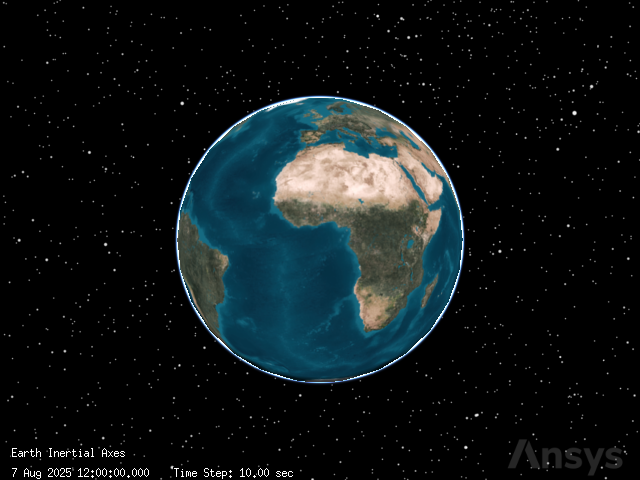

In [3]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import GlobeWidget


globe_plotter = GlobeWidget(root, 640, 480)
globe_plotter.show()

It is also possible to show a 2D graphics window by running:

RFBOutputContext()

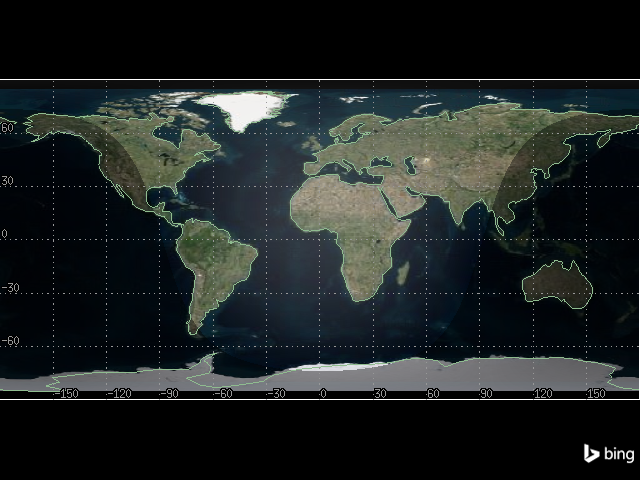

In [4]:
from ansys.stk.core.stkengine.experimental.jupyterwidgets import MapWidget


map_plotter = MapWidget(root, 640, 480)
map_plotter.show()

## Set the scenario time period

Using the newly created scenario, set the start and stop times. Rewind the scenario so that the graphics match the start and stop times of the scenario:

In [5]:
scenario = root.current_scenario
scenario.set_time_period("1 Jul 2016 16:00:00.000", "2 Jul 2016 16:00:00.000")
root.rewind()

## Add the air traffic control center

The air traffic control center's site is modeled with a place object. The radar site is located at  a latitude of $38.8006^\circ$ and a longitude of $-104.6784^\circ$. The radar's antenna is $50$ ft ($0.01524$ km) above the ground.

First, insert a place object to represent the airport's radar site:

In [6]:
from ansys.stk.core.stkobjects import STKObjectType


radar_site = scenario.children.new(STKObjectType.PLACE, "RadarSite")

Then, set the radar site's position using geodetic coordinates. Provide the latitude, longitude, and altitude corresponding to the radar's antenna:

In [7]:
radar_site.position.assign_geodetic(38.8006, -104.6784, 0.01524)

## Add relevant locations

Two places of interest in the vicinity of the radar site are Cheyenne, Wyoming, and Raton, New Mexico.

First, add a place object to represent Cheyenne:

In [8]:
cheyenne = scenario.children.new(STKObjectType.PLACE, "Cheyenne")

Cheyenne is located at a latitude of $41.1400^\circ$ and a longitude of $-104.8202^\circ$. Set the place's location to match Cheyenne's:

In [9]:
cheyenne.position.assign_geodetic(41.1400, -104.8202, 0)

Then, add a place object to represent Raton:

In [10]:
raton = scenario.children.new(STKObjectType.PLACE, "Raton")

Raton is located at a latitude of $36.9034^\circ$ and a longitude of $-104.4392^\circ$. Set the place's location to match Raton's:

In [11]:
raton.position.assign_geodetic(36.9034, -104.4392, 0)

## Add an aircraft

To determine how well the radar site can view aircraft flying between Cheyenne and Raton, introduce a test aircraft flying between the cities to use in access calculations.

First, insert an aircraft:

In [12]:
aircraft = scenario.children.new(STKObjectType.AIRCRAFT, "Aircraft")

Because the aircraft's route is defined by a set of waypoints, the aircraft's flight is modeled with a Great Arc propagator. Set the aircraft's propagator to the Great Arc propagator:

In [13]:
from ansys.stk.core.stkobjects import PropagatorType


aircraft.set_route_type(PropagatorType.GREAT_ARC)

The aircraft flies between Cheyenne and Raton, so the propagator's route must include waypoints for both locations.

First, add a waypoint to the aircraft's route to represent Cheyenne:

In [14]:
cheyenne_waypoint = aircraft.route.waypoints.add()

Set the waypoint's location to match Cheyenne's:

In [15]:
cheyenne_waypoint.latitude = 41.1400
cheyenne_waypoint.longitude = -104.8202

Then, add a waypoint to the route representing Raton:

In [16]:
raton_waypoint = aircraft.route.waypoints.add()

Set the waypoint's location to match Raton's:

In [17]:
raton_waypoint.latitude = 36.9034
raton_waypoint.longitude = -104.4392

Then, propagate the aircraft's route:

In [18]:
aircraft.route.propagate()

The 2D graphics window now shows the aircraft's route, as well as both cities and the radar site:

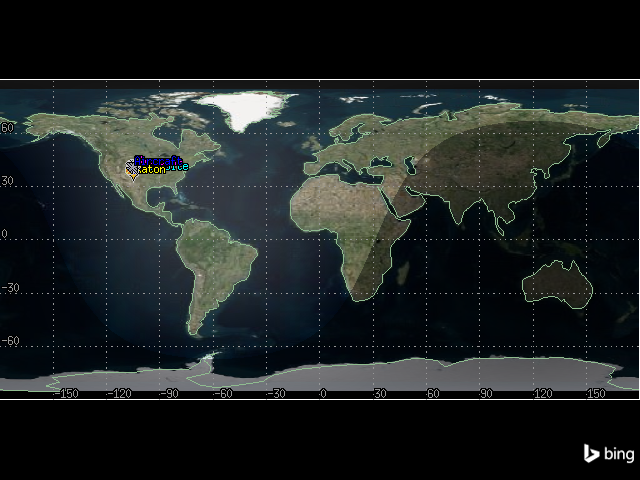

In [19]:
map_plotter.camera.position = [6110, 34540, 0.0]
map_plotter.show()

## Add a satellite

An imaging satellite flies in a low-earth circular orbit, with an inclination of $60^\circ$, an altitude of $800$ km, and a RAAN of $20^\circ$. Determine if this satellite can view a site of interest at Raton.

First, insert a satellite:

In [20]:
satellite = scenario.children.new(STKObjectType.SATELLITE, "ImageSat")

Set the satellite's propagator to J4Pertubation:

In [21]:
from ansys.stk.core.stkobjects import PropagatorType


satellite.set_propagator_type(PropagatorType.J4_PERTURBATION)
propagator = satellite.propagator

Set the orbit's coordinate type to classical:

In [22]:
from ansys.stk.core.stkutil import OrbitStateType


orbit = propagator.initial_state.representation.convert_to(OrbitStateType.CLASSICAL)

Use the returned `IOrbitStateClassical` object to set the `size_shape_type` property. This property designates which pair of elements describe the orbit. Set the `size_shape_type` to Semimajor Axis and Eccentricity:

In [23]:
from ansys.stk.core.stkobjects import ClassicalSizeShape


orbit.size_shape_type = ClassicalSizeShape.SEMIMAJOR_AXIS

Set the orbit's semimajor axis to $7178.14$ km and it's eccentricity to $0$:

In [24]:
orbit.size_shape.semi_major_axis = 7178.14
orbit.size_shape.eccentricity = 0

Then, use the `orientation` property of the `IOrbitStateClassical` object to set the inclination to $60^\circ$ and the argument of perigee to $0^\circ$:

In [25]:
orbit.orientation.inclination = 60
orbit.orientation.argument_of_periapsis = 0

Using the orientation property, set the ascending node type to RAAN:

In [26]:
from ansys.stk.core.stkobjects import OrientationAscNode


orbit.orientation.ascending_node_type = (
    OrientationAscNode.RIGHT_ASCENSION_ASCENDING_NODE
)

Set the RAAN value to $20^\circ$:

In [27]:
orbit.orientation.ascending_node.value = 20

Then, use the `location` property of the `IOrbitStateClassical` object to set the location type to true anomaly:

In [28]:
from ansys.stk.core.stkobjects import ClassicalLocation


orbit.location_type = ClassicalLocation.TRUE_ANOMALY

Set the true anomaly value to $0^\circ$:

In [29]:
orbit.location.value = 0

Finally, assign the orbit to the propagator and propagate the satellite:

In [30]:
satellite.propagator.initial_state.representation.assign(orbit)
satellite.propagator.propagate()

The satellite's orbit can now be seen in the 3D graphics window:

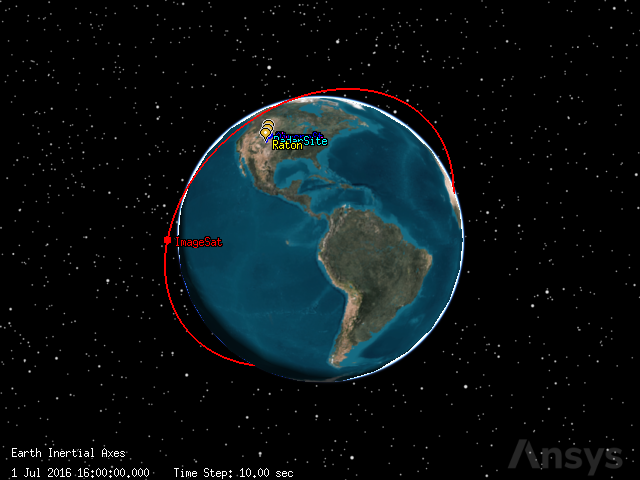

In [31]:
globe_plotter.show()

## Add a fixed sensor on the satellite

The satellite has two sensors. The first sensor is a fixed sensor. A fixed sensor always points in a fixed direction with respect to its parent object. Because this sensor is attached to the satellite, it points with respect to the satellite's reference frame. And because the satellite is a moving object, even though the sensor is fixed, the sensor's field-of-view changes along with the satellite's movement.

The fixed sensor has a simple conic pattern with a $45^\circ$ cone angle and an angular resolution of $1^\circ$. Determine if this sensor can see Raton during the analysis period.

First, insert a sensor on the satellite. By default, the sensor's type is fixed.

In [32]:
fixed_sat_sensor = satellite.children.new(STKObjectType.SENSOR, "FixedSatelliteSensor")

Then, set the sensor's pattern to simple conic with a cone half angle of $45^\circ$ and an angular resolution of $1^\circ$:

In [33]:
from ansys.stk.core.stkobjects import SensorPattern


fixed_sat_sensor.set_pattern_type(SensorPattern.SIMPLE_CONIC)
fixed_sat_sensor.common_tasks.set_pattern_simple_conic(45, 1)

It is possible to see the sensor's field of vision in the 3D graphics window:

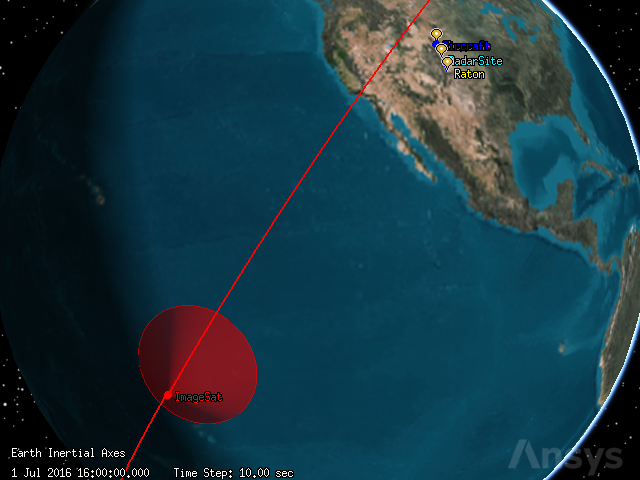

In [34]:
globe_plotter.camera.position = [12770, 9060, 4570]
globe_plotter.show()

## Compute fixed access

Determine if the fixed sensor on the satellite can take pictures of the site of interest in Raton during the analysis period. To do so, add Raton as an associated object to the sensor. Then, compute access.

Create an access object between the fixed sensor and Raton:

In [35]:
fixed_sat_access = fixed_sat_sensor.get_access_to_object(raton)

Use the access object to compute the accesses between the sensor and Raton:

In [36]:
fixed_sat_access.compute_access()

Then, use the access object's data providers to get an Access Data report for the time period between the scenario's start and end times. Convert the report to a pandas data frame for easier viewing:

In [37]:
fixed_sat_access.data_providers.item("Access Data").execute(
    scenario.start_time, scenario.stop_time
).data_sets.to_pandas_dataframe()

,access number,start time,stop time,duration,from pass number,to pass number,from start lat,from start lon,from start alt,from stop lat,...,from stop utm northing,from stop mgrs cell,to start utm zone,to start utm easting,to start utm northing,to start mgrs cell,to stop utm zone,to stop utm easting,to stop utm northing,to stop mgrs cell
0,1,1 Jul 2016 23:18:46.105978785,1 Jul 2016 23:22:28.508132578,222.4021537936569,5,N/A,44.64160606195129,-105.54934589619562,810.5207584145228,34.600431001996206,...,3831.066334023972,15STU9227431066,13S,549.9610548503704,4084.3031255548854,13SEA4996184303,13S,549.9610548503704,4084.3031255548854,13SEA4996184303
1,2,2 Jul 2016 15:44:40.789351295,2 Jul 2016 15:47:17.084610386,156.29525909059157,15,N/A,37.543106963651354,-114.17838758736924,807.9054072558267,44.502777565416324,...,4929.058972331137,13TCK6798329059,13S,549.9610548503704,4084.3031255548854,13SEA4996184303,13S,549.9610548503704,4084.3031255548854,13SEA4996184303


There are two rows in the dataframe, each corresponding to an access. The access durations were approximately 222 and 156 seconds.

## Add a moving sensor on a the satellite

Many satellites can gimbal their sensors to track other objects (stationary and moving). STK provides a variety of sensor definitions and pointing types that model this type of movement. In this scenario, the satellite has a second moving sensor targeted towards Raton. Compare the access times for Raton between the fixed and targeted sensors.

First, insert a sensor on the satellite:

In [38]:
moving_sat_sensor = satellite.children.new(
    STKObjectType.SENSOR, "MovingSatelliteSensor"
)

The sensor is inserted as a fixed sensor by default, so set the sensor's pointing type to targeted:

In [39]:
from ansys.stk.core.stkobjects import SensorPointing


moving_sat_sensor.set_pointing_type(SensorPointing.TARGETED)

Then, set the sensor's pattern to simple conic with a cone half angle of $5^\circ$ and an angular resolution of $1^\circ$:

In [40]:
moving_sat_sensor.set_pattern_type(SensorPattern.SIMPLE_CONIC)
moving_sat_sensor.common_tasks.set_pattern_simple_conic(5, 1)

Because the sensor is set to a pointing type, the sensor's `pointing` method now holds an `ISensorPointingTargeted` object, through which it is possible to add a target to the sensor. Add Raton as the target:

In [41]:
moving_sat_sensor.pointing.targets.add(raton.path)

## Compute targeted access

Determine how the access times for the targeted sensor compare to those for the fixed sensor.

First, create an access between the moving sensor and Raton:

In [42]:
moving_sat_access = moving_sat_sensor.get_access_to_object(raton)

Use the access object to compute the accesses between the sensor and Raton:

In [43]:
moving_sat_access.compute_access()

Then, use the access object's data providers to get an Access Data report for the time period between the scenario's start and end times and convert the report to a pandas data frame:

In [44]:
moving_sat_access.data_providers.item("Access Data").execute(
    scenario.start_time, scenario.stop_time
).data_sets.to_pandas_dataframe()

,access number,start time,stop time,duration,from pass number,to pass number,from start lat,from start lon,from start alt,from stop lat,...,from stop utm northing,from stop mgrs cell,to start utm zone,to start utm easting,to start utm northing,to start mgrs cell,to stop utm zone,to stop utm easting,to stop utm northing,to stop mgrs cell
0,1,1 Jul 2016 16:06:33.049809639,1 Jul 2016 16:21:57.152261250,924.1024516105075,1,N/A,20.285767650070557,-129.36604153658092,802.5562646358665,58.16700201092655,...,6450.603230623984,18VUK3821550603,13S,549.9610548503704,4084.3031255548854,13SEA4996184303,13S,549.9610548503704,4084.3031255548854,13SEA4996184303
1,2,1 Jul 2016 17:54:25.060501227,1 Jul 2016 18:06:09.207856720,704.1473554934373,2,N/A,40.539631854283336,-139.47752979369412,808.9974722813364,60.112559216728016,...,6663.973873723716,17VMG8588663974,13S,549.9610548503704,4084.3031255548854,13SEA4996184303,13S,549.9610548503704,4084.3031255548854,13SEA4996184303
2,3,1 Jul 2016 19:43:08.553027776,1 Jul 2016 19:52:18.294239363,549.7412115866955,3,N/A,57.46978939076494,-132.12885821785932,815.1702866187368,55.027278669767256,...,6098.299080227297,18UWF6496398299,13S,549.9610548503704,4084.3031255548854,13SEA4996184303,13S,549.9610548503704,4084.3031255548854,13SEA4996184303
3,4,1 Jul 2016 21:28:32.974179185,1 Jul 2016 21:41:19.335843053,766.3616638681815,4,N/A,60.0107019562527,-127.84050781624738,816.0143169833198,35.39156120417346,...,3917.3880958860636,19SCV7136517388,13S,549.9610548503704,4084.3031255548854,13SEA4996184303,13S,549.9610548503704,4084.3031255548854,13SEA4996184303
4,5,1 Jul 2016 23:12:41.033277783,1 Jul 2016 23:28:27.715572094,946.6822943115185,5,N/A,57.19384433048181,-132.49546371482245,815.0763929645328,16.825693733152512,...,1861.8648738498089,17QKU4087261865,13S,549.9610548503704,4084.3031255548854,13SEA4996184303,13S,549.9610548503704,4084.3031255548854,13SEA4996184303
5,6,2 Jul 2016 00:57:36.728203010,2 Jul 2016 01:11:41.846292923,845.1180899124702,6,N/A,49.553863449062,-138.36287266828663,812.3480198351768,9.558465306211271,...,1056.5968701679828,13PDL8980456597,13S,549.9610548503704,4084.3031255548854,13SEA4996184303,13S,549.9610548503704,4084.3031255548854,13SEA4996184303
6,7,2 Jul 2016 13:54:26.287735300,2 Jul 2016 14:09:07.052286736,880.7645514356118,14,N/A,9.642644126336576,-106.89257720820613,800.5985510809237,50.94133065418992,...,5645.458672879423,19UCS5043745459,13S,549.9610548503704,4084.3031255548854,13SEA4996184303,13S,549.9610548503704,4084.3031255548854,13SEA4996184303
7,8,2 Jul 2016 15:38:13.760676593,2 Jul 2016 15:53:50.041424933,936.2807483397046,15,N/A,18.605143905238382,-127.59884142877311,802.164835688554,57.74393438668241,...,6402.195283919831,18VUK7322002195,13S,549.9610548503704,4084.3031255548854,13SEA4996184303,13S,549.9610548503704,4084.3031255548854,13SEA4996184303


The targeted sensor is able to access Raton 8 times, as opposed to the fixed sensor's 2 accesses. The targeted sensor's accesses are also longer, ranging between approximately 549 and 946 seconds. The increased access is because the targeted sensor locks onto the assigned target using the sensor's boresight. This represents point-to-point access. Because the access is only constrained by the line-of-site, the targeted sensor can access Raton from horizon to horizon. The field of view of the fixed sensor has to pass over Raton to be able to access it, so the access time for the targeted sensor is much higher.

**Conclusion:** Both cameras attached to the imaging satellite have opportunities to take pictures of Raton.

## Add a fixed sensor on the radar site

Now, determine if the radar site can see an aircraft flying between Cheyenne and Raton. The site has two sensors, one of which is a fixed sensor. Sensors can be used to model instruments attached to stationary objects, such as Facility, Place, and Target objects. Fixed sensors attached to stationary objects also point with respect to the parent object’s reference frame. Since stationary objects never change position or direction, a fixed sensor on a fixed object always points in a fixed direction. The radar site has one fixed sensor representing the site's entire possible field of view.

First, add a sensor to the radar site. The sensor is inserted as a fixed sensor by default.

In [45]:
radar_dome_sensor = radar_site.children.new(STKObjectType.SENSOR, "RadarDome")

Then, set the sensor's pattern to simple conic with a cone half angle of $90^\circ$ and an angular resolution of $1^\circ$:

In [46]:
radar_dome_sensor.set_pattern_type(SensorPattern.SIMPLE_CONIC)
radar_dome_sensor.common_tasks.set_pattern_simple_conic(90, 1)

## Add a constraint to the sensor

The fixed sensor attached to the facility is similar to the fixed sensor attached to the imaging satellite. However, the site's sensor has a larger field-of-view, and instead of pointing straight down this sensor points straight up from the radar site. So, the sensor has an upwards looking field-of-view that covers everything above the site. This is not a realistic field of view, so limit the sensor's range so that the field-of-view spans a constrained area mimicking the field-of-view of the actual air traffic control radar. Limit the field-of-view to a maximum range of $150$ km.

First, add a range access constraint to the sensor:

In [47]:
from ansys.stk.core.stkobjects import AccessConstraintType


dome_range_constraint = radar_dome_sensor.access_constraints.add_constraint(
    AccessConstraintType.RANGE
)

Then, set the constraint to have a maximum range of $150$ km:

In [48]:
dome_range_constraint.enable_maximum = True
dome_range_constraint.maximum = 150

The sensor can now only see $150$ km in each direction.

## Configure the 2D projection properties

2D graphics projection properties for sensors control the display of sensor projection graphics in the 2D Graphics window. When the sensor's display is set to project to the range constraint, STK projects the sensor's field-of-view to the maximum range previously specified for the sensor.

Configure the sensor's 2D graphics properties to show a projection of the maximum range on the 2D map:

In [49]:
from ansys.stk.core.stkobjects import SensorProjectionDistanceType


radar_dome_sensor.graphics.projection.distance_type = (
    SensorProjectionDistanceType.RANGE_CONSTRAINT
)
radar_dome_sensor.graphics.projection.use_constraints = True
radar_dome_sensor.graphics.projection.show_on_2d_map = True

It is now possible to see the range of $150$ km around the radar site on the 2D graphics window:

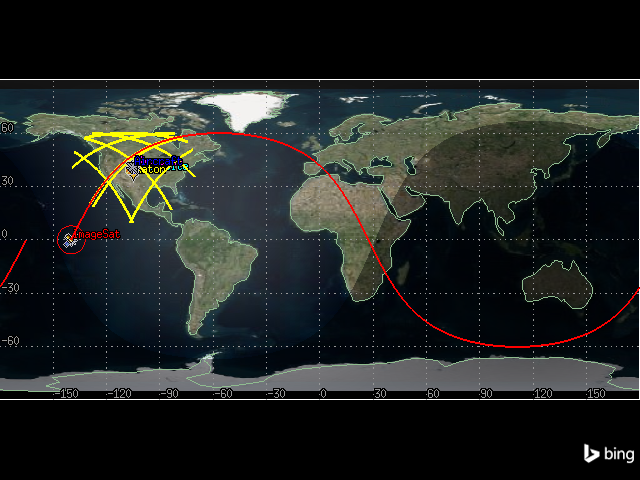

In [50]:
map_plotter.show()

## Calculate access

From the projection on the map, it is clear that the fixed sensor can access the flight along its route. Now, determine how long the sensor can access the flight for.

Create an access between the sensor and the aircraft:

In [51]:
radar_dome_access = radar_dome_sensor.get_access_to_object(aircraft)

Compute the accesses between the sensor and aircraft:

In [52]:
radar_dome_access.compute_access()

View the Access Data report for the scenario's duration as a pandas dataframe:

In [53]:
radar_dome_access_df = (
    radar_dome_access.data_providers.item("Access Data")
    .execute(scenario.start_time, scenario.stop_time)
    .data_sets.to_pandas_dataframe()
)

In [54]:
radar_dome_access_df

,access number,start time,stop time,duration,from pass number,to pass number,from start lat,from start lon,from start alt,from stop lat,...,from stop utm northing,from stop mgrs cell,to start utm zone,to start utm easting,to start utm northing,to start mgrs cell,to stop utm zone,to stop utm easting,to stop utm northing,to stop mgrs cell
0,1,1 Jul 2016 16:29:43.624000142,1 Jul 2016 17:22:37.004589558,3173.3805894163347,N/A,N/A,38.800599999999996,-104.6784,1.8668768006919723,38.800599999999996,...,4294.698440149648,13SEC2792694698,13S,525.280420811043,4417.174860867255,13SEE2528017175,13S,543.3819113064714,4173.175177047483,13SEB4338273175


The fixed sensor can view the aircraft for approximately $3173$ seconds.

## Generate an AER report

An AER (azimuth, elevation, and range) report describes the location of the aircraft when it is within the sensor's view. This data can be useful for many purposes, including air traffic control. To get the AER report, first select the AER Data report from the access's data providers. Then, select the Default report from the `IDataProviders` object stored in the `IDataProviderGroup`'s `group` property. Finally, convert the report to a pandas dataframe:

In [55]:
aer_df = (
    radar_dome_access.data_providers.item("AER Data")
    .group.item("Default")
    .execute(scenario.start_time, scenario.stop_time, 60)
    .data_sets.to_pandas_dataframe()
)

It is now possible to graph the azimuth, elevation, and range data:

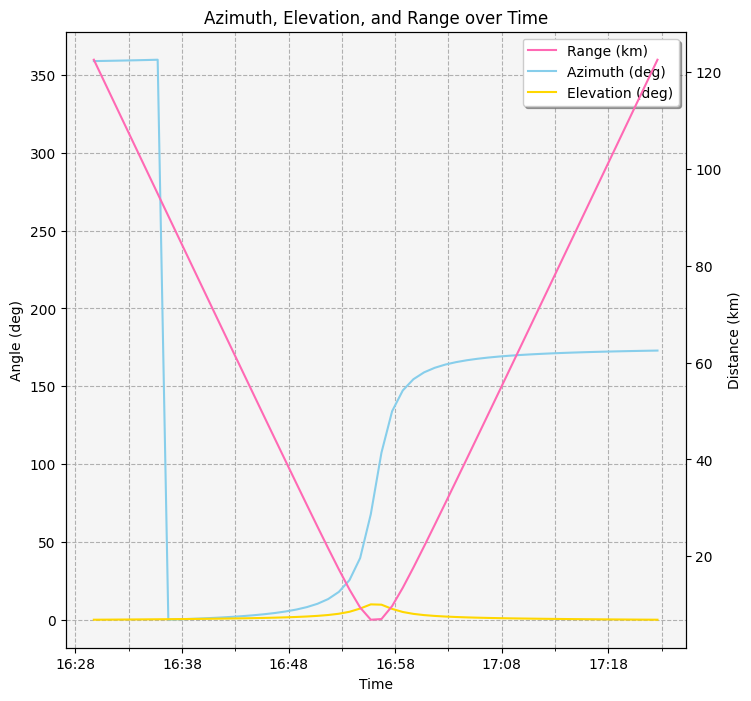

In [56]:
import matplotlib.dates as md
import matplotlib.pyplot as plt
import pandas as pd


# Convert columns to correct types
aer_df["time"] = pd.to_datetime(aer_df["time"])
aer_df.set_index("time", inplace=True)
cols = ["azimuth", "elevation", "range"]
aer_df[cols] = aer_df[cols].apply(pd.to_numeric)

# Create a plot and duplicate the x-axis
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()

# Plot range, azimuth, and elevation
(line1,) = ax2.plot(aer_df.index, aer_df["range"], color="hotpink", label="Range (km)")
(line2,) = ax1.plot(
    aer_df.index, aer_df["azimuth"], color="skyblue", label="Azimuth (deg)"
)
(line3,) = ax1.plot(
    aer_df.index, aer_df["elevation"], color="gold", label="Elevation (deg)"
)

# Set title and axes labels
ax1.set_title("Azimuth, Elevation, and Range over Time")
ax1.set_xlabel("Time")
ax1.set_ylabel("Angle (deg)")
ax2.set_ylabel("Distance (km)")

# Combine legends
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, shadow=True)

# Configure style
ax1.set_facecolor("whitesmoke")
ax1.grid(visible=True, which="both", linestyle="--")

# Improve x-axis formatting
formatter = md.DateFormatter("%H:%M")
ax1.xaxis.set_major_formatter(formatter)
# Set major and minor locators
xlocator_major = md.MinuteLocator(interval=10)
xlocator_minor = md.MinuteLocator(interval=5)
ax1.xaxis.set_major_locator(xlocator_major)
ax1.xaxis.set_minor_locator(xlocator_minor)
plt.show()

## Add a moving sensor to the control site

Often, the dome created by a fixed sensor object is used to model a field-of-view, or the overall volume of space in which radar looks. The radar itself often sweeps or scans through that field-of-view in a repeating cycle. The area of space represented by such a scanning or spinning radar at any given instant is its field-of-view. To model the aircraft control site's radar itself, build a sweeping radar beam using a moving sensor.

First, insert a sensor on the radar site:

In [57]:
radar_sweep_sensor = radar_site.children.new(STKObjectType.SENSOR, "RadarSweep")

To model a field-of-view of a radar, use a rectangular sensor. Rectangular sensor types are typically used for modeling the field-of-view of instruments such as push broom sensors and star trackers. Rectangular sensors are defined according to specified vertical and horizontal half-angles.

Set the radar's sensor pattern to a rectangular pattern with a $5^\circ$ vertical half angle and a $35^\circ$ horizontal half angle:

In [58]:
radar_sweep_sensor.set_pattern_type(SensorPattern.RECTANGULAR)
radar_sweep_sensor.common_tasks.set_pattern_rectangular(5, 35)

This sensor configuration creates a wedge type field-of-view. Right now, that “wedge” is just pointing straight up. The radar afixed to the radar site sweeps or scans in a repeating cycle. Since the radar “scans”, the full range of the radar is not always covered. Configure the sensor’s field-of-view to provide a visual representation of the area that the radar does cover at any given point in time. Set the properties of the sensor to rotate and point at $35^\circ$ elevation. Set the spin axis elevation to $90^\circ$ for horizontal rotation with a cone angle of $55^\circ$ for a $35^\circ$ elevation from the horizon.

First, set the radar's pointing type to spinning. This type of sensor is used to model radars, push broom sensors, and other instruments that spin, scan, or sweep over time.

In [59]:
radar_sweep_sensor.set_pointing_type(SensorPointing.SPINNING)

The sensor's `pointing` property now contains an `ISensorPointingSpinning` object. The spin rate property of this object describes the rate at which the boresight spins about the spin axis, measured in revolutions per minute. Set the spin rate to $12$ revs/min:

In [60]:
radar_sweep_sensor.pointing.spin_rate = 12

The spin axis cone angle of the object designates the cone angle used in defining the spin axis, i.e. the angle between the spin axis and the sensor boresight. Set the spin axis cone angle to $55^\circ$:

In [61]:
radar_sweep_sensor.pointing.spin_axis_cone_angle = 55

## Add a constraint to the sensor

Right now, the field-of-view extends beyond the limits of the actual radar (modeled with the fixed sensor) because there are no constraints on the moving sensor. The airport’s primary surveillance radar has a range of $150$ km, so limit the range of the moving sensor to model that constraint.

First, add a range constraint to the sweeping sensor:

In [62]:
sweep_range_constraint = radar_sweep_sensor.access_constraints.add_constraint(
    AccessConstraintType.RANGE
)

Then, configure the constraint to a maximum range of $150$ km:

In [63]:
sweep_range_constraint.enable_maximum = True
sweep_range_constraint.maximum = 150

## Configure the 2D projection properties

To view the moving sensor's field of view on the 2D graphics window, configure some of the sensors graphics properties:

In [64]:
from ansys.stk.core.utilities.colors import Color


radar_sweep_sensor.graphics.projection.distance_type = (
    SensorProjectionDistanceType.RANGE_CONSTRAINT
)
radar_sweep_sensor.graphics.projection.use_constraints = True
radar_sweep_sensor.graphics.projection.show_on_2d_map = True
radar_sweep_sensor.graphics.color = Color.from_rgb(247, 57, 57)
radar_dome_sensor.graphics.color = Color.from_rgb(199, 247, 87)

The sweeping radar's field-of-view can now be seen in red, while the fixed sensor's field-of-view is seen in yellow:

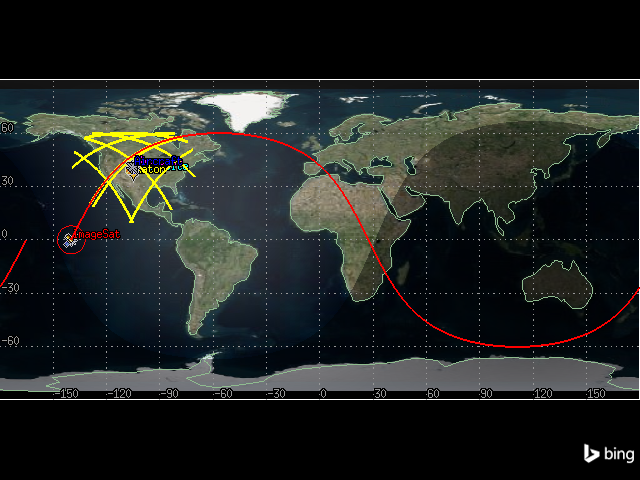

In [65]:
map_plotter.show()

## Calculate access

Now, determine when the sweeping radar sensor can see the aircraft flying between Cheyenne and Raton. To do so, first create an access between the sensor and the aircraft:

In [66]:
sweeping_access = radar_sweep_sensor.get_access_to_object(aircraft)

Then, compute the access:

In [67]:
sweeping_access.compute_access()

View the Access Data report as a pandas dataframe:

In [68]:
sweeping_access_df = (
    sweeping_access.data_providers.item("Access Data")
    .execute(scenario.start_time, scenario.stop_time)
    .data_sets.to_pandas_dataframe()
)

In [69]:
sweeping_access_df

,access number,start time,stop time,duration,from pass number,to pass number,from start lat,from start lon,from start alt,from stop lat,...,from stop utm northing,from stop mgrs cell,to start utm zone,to start utm easting,to start utm northing,to start mgrs cell,to stop utm zone,to stop utm easting,to stop utm northing,to stop mgrs cell
0,1,1 Jul 2016 16:29:44.959379948,1 Jul 2016 16:29:45.069238069,0.10985812090734726,N/A,N/A,38.800599999999996,-104.6784,1.8668768006919723,38.800599999999996,...,4294.698440149648,13SEC2792694698,13S,525.2880471455817,4417.072186212919,13SEE2528817072,13S,525.2886745434362,4417.0637394439145,13SEE2528917064
1,2,1 Jul 2016 16:29:49.957907071,1 Jul 2016 16:29:50.067158543,0.10925147191278484,N/A,N/A,38.800599999999996,-104.6784,1.8668768006919723,38.800599999999996,...,4294.698440149648,13SEC2792694698,13S,525.3165936075204,4416.687859540542,13SEE2531716688,13S,525.3172175389718,4416.6794594147095,13SEE2531716679
2,3,1 Jul 2016 16:29:54.958925769,1 Jul 2016 16:29:55.068941395,0.11001562633441608,N/A,N/A,38.800599999999996,-104.6784,1.8668768006919723,38.800599999999996,...,4294.698440149648,13SEC2792694698,13S,525.3451542144485,4416.303341257241,13SEE2534516303,13S,525.3457825081036,4416.29488237626,13SEE2534616295
3,4,1 Jul 2016 16:29:59.957342786,1 Jul 2016 16:30:00.066790864,0.10944807754867725,N/A,N/A,38.800599999999996,-104.6784,1.8668768006919723,38.800599999999996,...,4294.698440149648,13SEC2792694698,13S,525.373699878892,4415.91902297327,13SEE2537415919,13S,525.3743249294548,4415.91060772913,13SEE2537415911
4,5,1 Jul 2016 16:30:04.958727379,1 Jul 2016 16:30:05.069065928,0.11033854954098388,N/A,N/A,38.800599999999996,-104.6784,1.8668768006919723,38.800599999999996,...,4294.698440149648,13SEC2792694698,13S,525.402262406432,4415.534476479608,13SEE2540215534,13S,525.4028925405532,4415.525992768,13SEE2540315526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,631,1 Jul 2016 17:22:12.542224315,1 Jul 2016 17:22:12.653353757,0.1111294416596138,N/A,N/A,38.800599999999996,-104.6784,1.8668768006919723,38.800599999999996,...,4294.698440149648,13SEC2792694698,13S,543.2425746781303,4175.056096733071,13SEB4324375056,13S,543.2432076749731,4175.047551954639,13SEB4324375048
631,632,1 Jul 2016 17:22:17.544283581,1 Jul 2016 17:22:17.651152843,0.10686926212838443,N/A,N/A,38.800599999999996,-104.6784,1.8668768006919723,38.800599999999996,...,4294.698440149648,13SEC2792694698,13S,543.2710664940284,4174.671486767361,13SEB4327174671,13S,543.2716752215562,4174.663269554475,13SEB4327274663
632,633,1 Jul 2016 17:22:22.542340083,1 Jul 2016 17:22:22.654827862,0.11248777895161766,N/A,N/A,38.800599999999996,-104.6784,1.8668768006919723,38.800599999999996,...,4294.698440149648,13SEC2792694698,13S,543.2995353604724,4174.287184527559,13SEB4330074287,13S,543.3001760877119,4174.278535303976,13SEB4330074279
633,634,1 Jul 2016 17:22:27.543842019,1 Jul 2016 17:22:27.654655324,0.11081330513934518,N/A,N/A,38.800599999999996,-104.6784,1.8668768006919723,38.800599999999996,...,4294.698440149648,13SEC2792694698,13S,543.3280237022229,4173.902617319151,13SEB4332873903,13S,543.328654888386,4173.894096845366,13SEB4332973894


The sweeping radar is able to access the aircraft 635 times during the aircraft's flight, as indicated by the 635 rows in the dataframe.

Now, use the dataframe to convert the duration column to numeric form and calculate the average duration of access between the sensor and the aircraft:

In [70]:
import pandas as pd


sweeping_access_df["duration"] = pd.to_numeric(sweeping_access_df["duration"])
sweeping_access_df.mean(numeric_only=True)["duration"]

np.float64(0.11147695893969853)

The average duration of access was approximately $0.111$ seconds.

## Visualize access with a graph

The duration and time of access can be visualized with a graph.

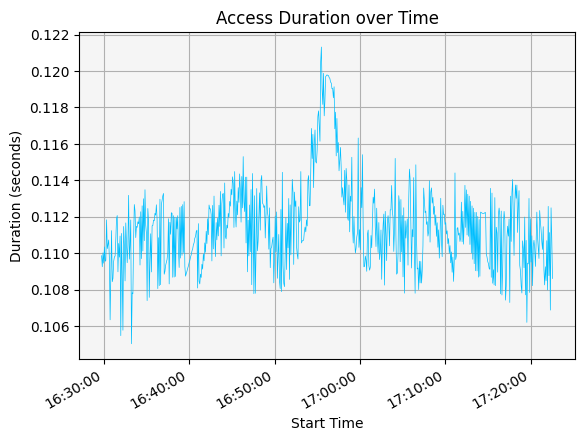

In [71]:
import matplotlib.dates as md


# Convert data to correct type
sweeping_access_df["start time"] = pd.to_datetime(sweeping_access_df["start time"])

# Plot data
ax = sweeping_access_df.plot(
    x="start time", y="duration", color="deepskyblue", linewidth=0.5
)

# Set title and axes labels
ax.set_title("Access Duration over Time")
ax.set_xlabel("Start Time")
ax.set_ylabel("Duration (seconds)")

# Configure the style of the plot
ax.get_legend().remove()
ax.set_facecolor("whitesmoke")
ax.grid(visible=True, which="both")

# Improve x-axis formatting
formatter = md.DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(formatter)

plt.show()

## Analyze multiple accesses

Create an access graph that shows all four sensors and their accesses to the aircraft. There are already existing calculations in this scenario for the access between the radar site's fixed and moving sensors and the aircraft. However, there are no access calculations between either of the sensors on the satellite and the aircraft.

First, create an access between the satellite's fixed sensor and the aircraft:

In [72]:
fixed_aircraft_access = fixed_sat_sensor.get_access_to_object(aircraft)

Then, compute the access:

In [73]:
fixed_aircraft_access.compute_access()

Convert the "Access Duration" report to a pandas dataframe:

In [74]:
fixed_aircraft_access_df = (
    fixed_aircraft_access.data_providers.item("Access Data")
    .execute(scenario.start_time, scenario.stop_time)
    .data_sets.to_pandas_dataframe()
)

Then, create an access between the satellite's moving sensor and the aircraft:

In [75]:
moving_aircraft_access = moving_sat_sensor.get_access_to_object(aircraft)

Then, compute the access:

In [76]:
moving_aircraft_access.compute_access()

Finally, convert the "Access Duration" report to a pandas dataframe:

In [77]:
moving_aircraft_access_df = (
    moving_aircraft_access.data_providers.item("Access Data")
    .execute(scenario.start_time, scenario.stop_time)
    .data_sets.to_pandas_dataframe()
)

Now, there are access duration reports for the accesses between all four sensors in the scenario and the aircraft. Group these reports into a list:

In [78]:
access_reports = [
    fixed_aircraft_access_df,
    moving_aircraft_access_df,
    sweeping_access_df,
    radar_dome_access_df,
]

Convert the start and stop times for each report to a time format, and the duration columns to a time delta format:

In [79]:
for report in access_reports:
    report["start time"] = pd.to_datetime(report["start time"])
    report["stop time"] = pd.to_datetime(report["stop time"])
    report["duration"] = pd.to_numeric(report["duration"])
    report["duration"] = pd.to_timedelta(report["duration"], unit="seconds")

Then, graph all the reports together in an event plot:

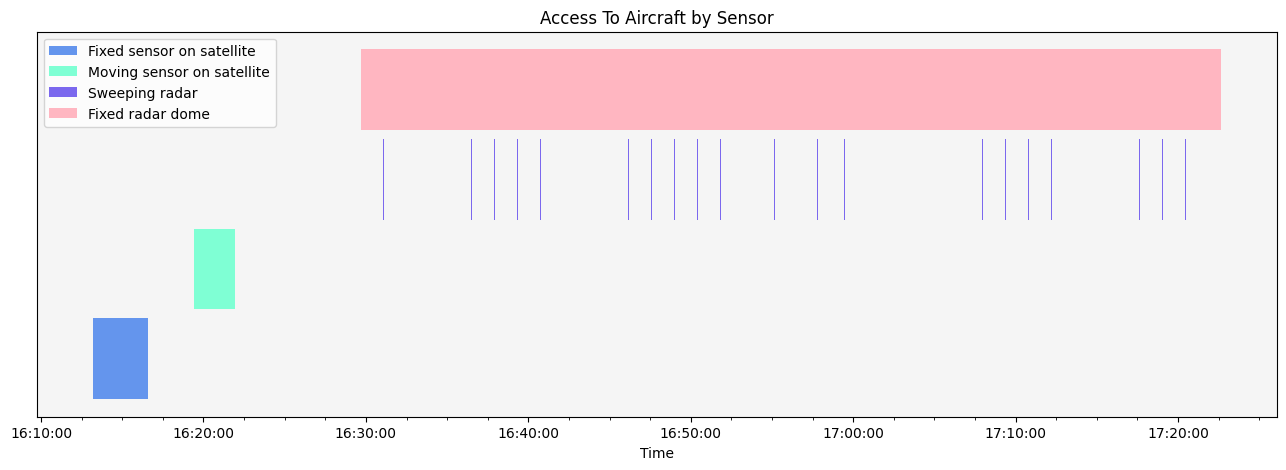

In [80]:
import datetime as dt


# Create plot
fig, ax = plt.subplots()
ax.broken_barh(
    list(
        zip(
            fixed_aircraft_access_df["start time"], fixed_aircraft_access_df["duration"]
        )
    ),
    (10, 9),
    facecolors="cornflowerblue",
    label="Fixed sensor on satellite",
)
ax.broken_barh(
    list(
        zip(
            moving_aircraft_access_df["start time"],
            moving_aircraft_access_df["duration"],
        )
    ),
    (20, 9),
    facecolors="aquamarine",
    label="Moving sensor on satellite",
)
ax.broken_barh(
    list(zip(sweeping_access_df["start time"], sweeping_access_df["duration"])),
    (30, 9),
    facecolors="mediumslateblue",
    label="Sweeping radar",
)
ax.broken_barh(
    list(zip(radar_dome_access_df["start time"], radar_dome_access_df["duration"])),
    (40, 9),
    facecolors="lightpink",
    label="Fixed radar dome",
)

# Set title and axes labels
ax.set_title("Access To Aircraft by Sensor")
ax.set_xlabel("Time")
ax.get_yaxis().set_visible(False)

# Configure the style of the plot
ax.legend()
ax.set_facecolor("whitesmoke")

# Set the size of the plot
fig.set_size_inches(16, 5)

# Improve x-axis formatting
formatter = md.DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(formatter)
ax.minorticks_on()

plt.show()

The graph shows that all of the sensors can see the aircraft during its flight, with the fixed radar dome able to see the aircraft for the longest duration of time. However, because the sweeping radar sees the aircraft for very short bursts of time, it is difficult to make out the different accesses. To better see the sweeping radar's accesses, create a plot zoomed in on the access between 16:54 and 16:56.

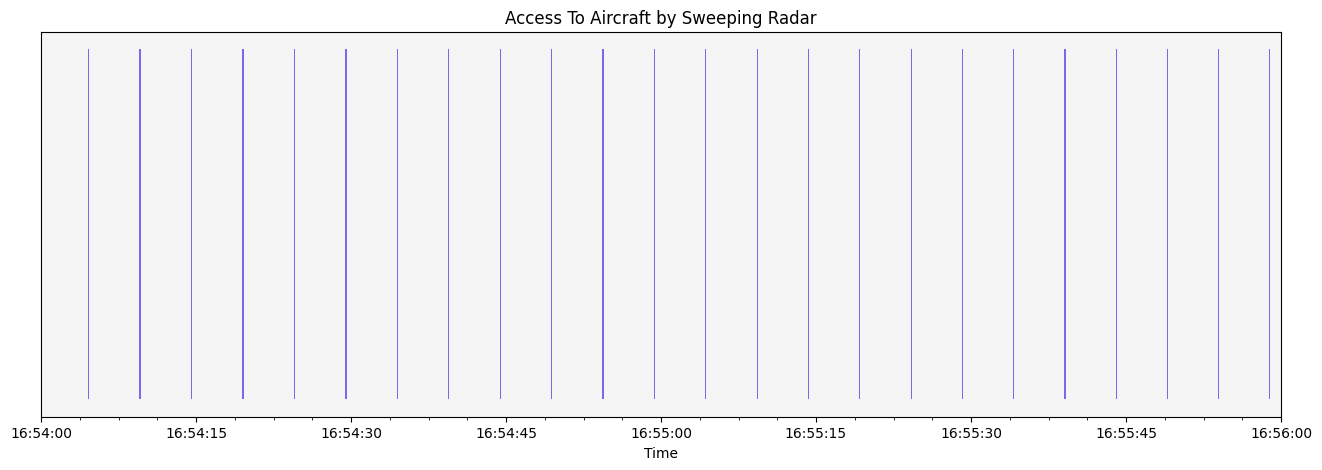

In [81]:
# Create plot
fig, ax = plt.subplots()
ax.broken_barh(
    list(zip(sweeping_access_df["start time"], sweeping_access_df["duration"])),
    (30, 9),
    facecolors="mediumslateblue",
    label="Sweeping radar",
)

# Set title and axes labels
ax.set_title("Access To Aircraft by Sweeping Radar")
ax.set_xlabel("Time")
ax.get_yaxis().set_visible(False)

# Configure the style of the plot
ax.set_facecolor("whitesmoke")

# Set the size of the plot
fig.set_size_inches(16, 5)

# Improve x-axis formatting
formatter = md.DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(formatter)
ax.minorticks_on()
ax.set_xlim(
    left=dt.datetime(2016, 7, 1, 16, 54, 0), right=dt.datetime(2016, 7, 1, 16, 56, 0)
)

plt.show()

**Conclusion:** All of the sensors involved in the scenario can see the aircraft during its flight.